In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, GridSearchCV)
from models import (get_RF, get_DT, get_knn, get_SVC, get_GBC, get_MLP, run_classifier)
from helper_functions import (k_fold_cv, hr,\
     get_sampler, plot_confusion_matrices, plot_roc)
import pickle
from sklearn.feature_selection import mutual_info_classif, GenericUnivariateSelect


In [2]:
path = "data/heart_cleveland_upload.csv"

In [3]:
heart_data = pd.read_csv(path)

In [4]:
heart_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


In [5]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


That means there are no Null values in this dataset

In [6]:
# Seperate Input and Target variables
heart_X = heart_data.drop(columns="condition", axis=1)
heart_y = heart_data['condition']

In [7]:
heart_X.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.120795
sex,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.370556
cp,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.266275
trestbps,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.130612
chol,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.023441
fbs,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.051038
restecg,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.013612
thalach,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.258386
exang,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.323268
oldpeak,0.197123,0.106567,0.203244,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.336809


From the table above, we can see that no two columns have a high correlation

In [8]:
# transformer = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=12)
# cols = heart_X.columns
# heart_X = transformer.fit_transform(heart_X, heart_y)
# print("Retained Features: ", transformer.get_feature_names_out(cols))

After experimenting with features, I discovered that Feature Selection is not required

In [9]:
#Using Standardization to Scale input features
from sklearn.preprocessing import (StandardScaler, RobustScaler)

std_scaler = StandardScaler()
#std_scaler = RobustScaler()

heart_X_scaled = std_scaler.fit_transform(heart_X)

In [10]:
sampler = get_sampler("RandomOverSampler", {"sampling_strategy": 1})

heart_X_scaled, heart_y = sampler.fit_resample(heart_X_scaled, heart_y)

<AxesSubplot: >

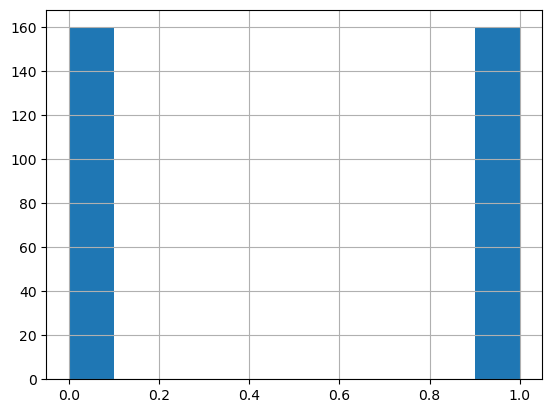

In [11]:
heart_y.hist()

From the histogram, we can see that we have 160 negative examples and 137 positive examples. Thus the data is not imbalanced

In [ ]:
def k_fold_cv(classifier, sampler,  X, y, cv, score_name="accuracy"):
    scorers = {
        "accuracy": accuracy_score,
        "recall": recall_score,
        "f1": f1_score,
        "roc_auc": roc_auc_score,
        "balanced_accuracy": balanced_accuracy_score
    }

    scores = []
    for train_folds_idx, val_fold_idx in cv.split(X, y):
        X_train_fold, y_train_fold = X[train_folds_idx], y[train_folds_idx]
        X_val_fold, y_val_fold = X[val_fold_idx], y[val_fold_idx]
        if sampler is None:
            X_sampled_train, y_sampled_train = X_train_fold, y_train_fold
        else:
            X_sampled_train, y_sampled_train = sampler.fit_resample(X_train_fold, y_train_fold)
        model_obj = classifier.fit(X_sampled_train, y_sampled_train)
        score = scorers[score_name](y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)

    return np.array(scores).mean()

In [12]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(heart_X_scaled, heart_y, test_size=0.33, random_state=0, stratify=heart_y)

In [13]:
#Constructing parameter dictionary for hyperparameter tuning
classifier_param_dict = [
    {
        "min_samples_leaf": [2, 3, 4, 5],
        "criterion": ["gini", "entropy", "log_loss"],
        "random_state": [0],
        "min_samples_split": [2, 3, 5],
        "min_weight_fraction_leaf": [0.0, 0.1, 0.3, 0.5],
        "max_features": ["sqrt", "log2"]
        },
    {
        "max_depth": [3, 5, 7],
        "random_state": [0], 
        "criterion": ["gini", "entropy", "log_loss"],
        "min_weight_fraction_leaf": [0.0, 0.1, 0.3, 0.5],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False]
        },
    {
        "kernel": ("linear", "poly", "rbf"),
        "degree": [1, 2, 3],
        "random_state": [0],
        "C": [0.01, 0.1, 1, 10],
        "probability": [True],
        },
    {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "leaf_size": [10, 30, 50],
        "p": [1, 2, 3]
        },
    {
        "loss": ["log_loss", "exponential"],
        'criterion': ['friedman_mse', 'squared_error'],
        'subsample': [0.1, 0.3, 0.5, 1],
        'learning_rate': [0.001, 0.01, 0.1],
        'n_estimators': [50, 100, 500],
        'max_depth': [3, 5],
        "random_state": [0],
        'max_features': ['sqrt', 'log2']
        },
    {
        "hidden_layer_sizes": [(512, 256, 64, 16, 4), (256, 128, 32, 8), (64, 32, 8)],
        'activation': ['tanh', 'relu'],
        "random_state": [0],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.01, 0.1],
        'learning_rate': ['constant','adaptive'],
        'max_iter': [500]
    }
]

classifiers = [get_DT, get_RF, get_SVC, get_knn, get_GBC, get_MLP]
names = ["DecisionTree", "RandomForest", "SVC", "k-NN", "GradientBoostingClassifier", "MLP"]

In [ ]:
#initialise the object for CV sampler
# We will use "Accuracy" as we are concerned with identifying all the patients with heart-diseases, i.e
# We want to identify all True Positives and it is fine to have a few False Positives, but no False Negatives
acc= []
std = []
def run_search():
    best_params = {} 
    for i in range(len(classifiers)):
        print("\nFinding out the best Parameters for ", names[i])
        # Using GridSearch to get the best combination of parameters
        classifier = GridSearchCV(classifiers[i](), classifier_param_dict[i], verbose=1, scoring="recall")
        classifier.fit(X_train, y_train)
        best_params[names[i]] = classifier.best_params_
        print(best_params[names[i]])
    with open('best_heart_param_dict.pkl', 'wb') as f:
        pickle.dump(best_params, f)

# Run the function below to generate a dictionary containing the best parameters for all the classifiers
run_search()

# Load the best parameters
with open('best_heart_param_dict.pkl', 'rb') as f:
    best_param = pickle.load(f)



Finding out the best Parameters for  DecisionTree
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1, 'random_state': 0}

Finding out the best Parameters for  RandomForest
Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_weight_fraction_leaf': 0.0, 'random_state': 0}

Finding out the best Parameters for  SVC
Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'C': 10, 'degree': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}

Finding out the best Parameters for  k-NN
Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'leaf_size': 10, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

Finding out the best Parameters for  GradientBoostingClassifier
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'crite

/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/pranshuldobriyal/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization

In [ ]:
# Train all classifiers with best parameter values we obtained above
for i in range(len(classifiers)):
    name = names[i] 
    classifier = classifiers[i](best_param[names[i]])
    met = run_classifier(classifier, X_train, y_train, X_test, y_test, split=False)
    plot_confusion_matrices("classifying_heart_disease", met, name)
    plot_roc("classifying_heart_disease", met["ROC"], name)

## Working on the Labor Negotiation Data =>

In [ ]:
headers = ["duration", "wage increase first year", "wage increase second year", "wage increase third year",\
           "cost of living adjustment", "working hours", "pension", "standby pay", "shift differential",\
           "education allowance", "statutory holidays", "vacation", "longterm disability assistance",\
           "contribution to dental plan", "bereavement assistance", "contribution to health plan", 'negotiations']

In [ ]:
train_labor_data = pd.read_csv('data/labor-neg.data', header=None, names=headers, na_values = "?")
train_labor_data.head()

In [ ]:
train_labor_data.describe()

In [ ]:
test_labor_data = pd.read_csv('data/labor-neg.test', header=None, names=headers, na_values="?")
test_labor_data.head()

In [ ]:
test_labor_data.describe()

Let us handle the Missing Values values now

In [ ]:
train_labor_data.negotiations.info()

In [ ]:
test_labor_data.negotiations.info()

There are no examples with missing values for the target column

In [ ]:
# For certain columns, it would make sense to fill missing values with the Mean of column
col_names = ["wage increase first year", "wage increase second year", "wage increase third year", "working hours",\
            "shift differential", "statutory holidays", "duration"]

for i in col_names:
    train_labor_data[i] = train_labor_data[i].fillna(train_labor_data[i].mean())
    test_labor_data[i] = test_labor_data[i].fillna(test_labor_data[i].mean())

In [ ]:
# Certain features have a very high number of missing values, hence it would make sense to drop them
col_names = ["standby pay", "cost of living adjustment", "pension"]

for i in col_names:
    train_labor_data = train_labor_data.drop([i],axis=1)
    test_labor_data = test_labor_data.drop([i],axis=1)

In [ ]:
train_labor_data.head()

In [ ]:
# Handling Categorical Missing Values by filling with most frequent element
from sklearn.impute import SimpleImputer

col_names = ["education allowance", "vacation", "longterm disability assistance", "contribution to dental plan",\
            "bereavement assistance", "contribution to health plan"]

imputer = SimpleImputer(strategy='most_frequent')

for i in col_names:
    train_labor_data[i] = imputer.fit_transform(np.array(train_labor_data[i]).reshape(-1, 1))
    test_labor_data[i] = imputer.fit_transform(np.array(test_labor_data[i]).reshape(-1, 1))
    

In [ ]:
train_labor_data.head()

#### Time to convert Categorical Data into Numeric

In [ ]:

col_names = ["education allowance", "vacation", "longterm disability assistance", "contribution to dental plan",\
            "bereavement assistance", "contribution to health plan"]

for i in col_names:
    encoded_data = pd.get_dummies(train_labor_data[i], prefix=i)
    train_labor_data = pd.concat([train_labor_data, encoded_data], axis = 1)
    train_labor_data.drop([i], axis=1, inplace=True)
    
    encoded_data = pd.get_dummies(test_labor_data[i], prefix=i)
    test_labor_data = pd.concat([test_labor_data, encoded_data], axis = 1)
    test_labor_data.drop([i], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

train_labor_data["negotiations"] = LabelBinarizer().fit_transform(train_labor_data["negotiations"])
test_labor_data["negotiations"] = LabelBinarizer().fit_transform(test_labor_data["negotiations"])

In [ ]:
train_labor_data.head()

In [ ]:
train_labor_data.corr() > 0.8

In [ ]:
# Splitting into train and test
X_train = train_labor_data.drop(columns="negotiations", axis=1)
y_train = train_labor_data['negotiations']
X_test = test_labor_data.drop(columns="negotiations", axis=1)
y_test = test_labor_data["negotiations"]

In [ ]:
y_train.value_counts()

The data is not highly imbalanced

In [ ]:
#Using Standardization to Scale input features

std_scaler = StandardScaler()
#std_scaler = RobustScaler()

X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

In [ ]:
acc= []
std = []
def run_labor_search():
    best_params = {} 
    for i in range(len(classifiers)):
        print("\nFinding out the best Parameters for ", names[i])
        # Using GridSearch to get the best combination of parameters
        classifier = GridSearchCV(classifiers[i](), classifier_param_dict[i], verbose=1, scoring="accuracy")
        classifier.fit(X_train, y_train)
        best_params[names[i]] = classifier.best_params_
        print(best_params[names[i]])
    with open('best_labor_param_dict.pkl', 'wb') as f:
        pickle.dump(best_params, f)

# Run the function below to generate a dictionary containing the best parameters for all the classifiers
run_labor_search()

In [ ]:
# Load the best parameters
with open('best_labor_param_dict.pkl', 'rb') as f:
    best_param = pickle.load(f)

In [ ]:
for i in range(len(classifiers)):
    name = names[i] 
    param = best_param[names[i]]
    if name == "MLP":
        param["max_iter"] = 1000
    else:
        continue
    classifier = classifiers[i](param)

    met = run_classifier(classifier, X_train, y_train, X_test, y_test, split=False)
    plot_confusion_matrices("classifying_labor_neg", met, name)
    plot_roc("classifying_labor_neg", met["ROC"], name)